In [26]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
from langchain_ollama.llms import OllamaLLM
import unittest
import importlib.util
from IPython.display import Image
import re
import pytest
import subprocess

In [27]:
class State(TypedDict):
    task: str
    code:str
    tests:str
    test_results:str
    comments: str


In [28]:
llm = OllamaLLM(model="codellama:13b")

### Nodes

In [29]:
# Nodes
def generate_code(state: State):
    """First LLM call to generate code"""

    msg = llm.invoke(f"""Write a python program for {state['task']}.
                        **Do not include explanations**, only executable function code. 
                        Ensure the function has proper indentation and no markdown syntax.""")
    # print(msg)
    exec_code = extract_code(msg)
    return {"code": exec_code}

def generate_test(state: State):
    """Second LLM call to generate the tests"""
    msg = llm.invoke(f"""Write unit tests for {state['code']} using python pytest. 
                        Only return valid Python code, with no explanations or markdown.
                        """)
    # print(msg)
    exec_code = extract_code(msg)
    return {"tests": exec_code}

def run_tests(state:State):
    """function to execute the tests and show results"""
    # Save generated code
    with open("generated_code.py", "w") as f:
        f.write(state["code"])

    # Save generated tests
    with open("test_generated_code.py", "w") as f:
        f.write(state["tests"])

    module_name = "generated_code"
    module_path = "generated_code.py"
    test_path = "test_generated_code.py"

    # Ensure both generated code and test files exist
    if not os.path.exists(module_path):
        print("Error: generated_code.py not found.")
        return
    if not os.path.exists(test_path):
        print("Error: test_generated_code.py not found.")
        return

    # Inject import statement into test file if missing
    with open(test_path, "r") as f:
        test_code = f.read()

    if f"from {module_name} import" not in test_code:
        with open(test_path, "w") as f:
            f.write(f"from {module_name} import *\n" + test_code)
            
    result = execute_tests(test_path)
    return {"test_results": "Passed" if result['exit_code'] == 0 else "Failed"}

def review(state:State):
    """Peer Review""" ## yes --> comments to fix the code. no -> end
    if state["test_results"] == 'Failed':
        return {"comments": "yes"}
    return {"comments":"no"}

def extract_code(response: str) -> str:
    """Extract valid Python code from model response."""
    code_match = re.search(r"```python(.*?)```", response, re.DOTALL)
    return code_match.group(1).strip() if code_match else response.strip()

def execute_tests(test_name: str) -> dict:
    result = subprocess.run(["pytest", test_name, "-q", "--color=no"],
                            capture_output=True, text=True)
    output = result.stdout

    # Extract "X passed, Y failed" from output
    match = re.search(r"(\d+) passed.*?(\d+) failed", output)

    if match:
        passed = int(match.group(1))
        failed = int(match.group(2))
    else:
        passed = int(re.search(r"(\d+) passed", output).group(1)) if "passed" in output else 0
        failed = int(re.search(r"(\d+) failed", output).group(1)) if "failed" in output else 0
    
    return {"passed": passed, "failed": failed, "exit_code": result.returncode}


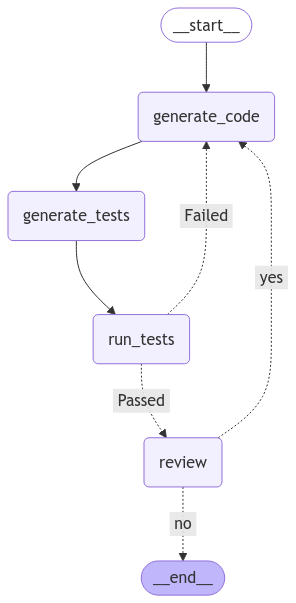

In [30]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_code", generate_code)
workflow.add_node("generate_tests", generate_test)
workflow.add_node("run_tests", run_tests)
workflow.add_node("review", review)

# Add edges to connect nodes
workflow.add_edge(START, "generate_code")
workflow.add_edge("generate_code", "generate_tests")
workflow.add_conditional_edges(
    "run_tests",
    lambda state: state["test_results"],
    {
        "Failed": "generate_code",
        "Passed": "review"
    }
)

workflow.add_conditional_edges(
    "review",
    lambda state: state["comments"],
    {
        "yes": "generate_code",
        "no": END
    }
)
workflow.add_edge("generate_tests", "run_tests")

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [31]:
# Invoke
state = chain.invoke({"task": "write a program to find a number is prime"})

In [32]:
state['test_results']

'Passed'